# Предсказание удержания клиентов интернет-магазина

Необходимо выбрать наилучшую модель для предсказания вероятности снижения покупательсткой активностьи.

## Цель
С помощью модели необходимо повысить покупательсткую активность различных каптегорий клиентов
 - выбрать и обучить модель, наилучшим образом предсказывающую покеупательскую способность пользоываелей;
 - выделить сегменты клиентов с учётом выручки бизнеса, покупательской способности и других зарактеристик пользваотелей;
 - разработать для каждого выделенного сегмента клиентов стратегии, повышаюшие удержание

## Описание данных:
### Поведение покупателя
- `id` — уникальный идентификатор покупателя в корпоративной базе данных.
- `Покупательская активность` — целевой признак, показывающий класс покупательской активности: «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса («премиум» или «стандарт»), зависящий от наличия подписки.
- `Разрешить сообщать` — бинарный признак (да, нет), указывающий, можно ли присылать клиенту дополнительные предложения.
- `Маркет_актив_6_мес` — среднемесячное количество маркетинговых коммуникаций за последние 6 месяцев (рассылки, звонки, реклама).
- `Маркет_актив_тек_мес` — число маркетинговых коммуникаций в текущем месяце.
- `Длительность` — количество дней с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от всех покупок за последние 6 месяцев.
- `Популярная_категория` — наиболее часто покупаемая категория товаров за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — среднее число категорий, просмотренных за один визит за последний месяц.
- `Неоплаченные_продукты_штук_квартал` — количество неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев сервиса, затронувших клиента за последние 3 месяца.
- `Страниц_за_визит` — среднее количество страниц, просмотренных клиентом за визит за последние 3 месяца.
### Выручка от покупателя
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период в условных единицах.
### Время, проведённое покупателем на сайте
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.
### Прибыль от покупателя
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли в условных единицах.

## План исследования

1) Предобработка данных
2) Исследовательский анализ данных
3) Подготовка данных к ML
4) Корреляционный анализ
5) Построение пайплайнов для выбора лучшей модели
6) Анализ важности признаков
7) Сегментация покупателей
8) Общий вывод

##  Предобработка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import phik
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
try:
    market = pd.read_csv(r".\source\market_file.csv", sep=',')
    market_revenue = pd.read_csv(r".\source\market_money.csv", sep=',')
    market_time = pd.read_csv(r".\source\market_time.csv", sep=',')
    profit = pd.read_csv(r".\source\money.csv", sep=';')
except:
    market = pd.read_csv(r"./datasets/market_file.csv", sep=',')
    market_money = pd.read_csv(r"./datasets/market_money.csv", sep=',')
    market_time = pd.read_csv(r"./datasets/market_time.csv", sep=',')
    profit = pd.read_csv(r"./datasets/money.csv", sep=';')

pd.set_option('display.max_columns', None)
print(f"Market data:\n{market.head(20)}")
print(f"Market revenue:\n{market_revenue.head(20)}")
print(f"Time spent on site:\n{market_time.head(20)}")
print(f"Market profit:\n{profit.head(20)}")

Market data:
    id       Покупательская активность   Тип сервиса   Разрешить сообщать  \
0   215348   Снизилась                   премиум       да                   
1   215349   Снизилась                   премиум       да                   
2   215350   Снизилась                   стандартт     нет                  
3   215351   Снизилась                   стандартт     да                   
4   215352   Снизилась                   стандартт     нет                  
5   215353   Снизилась                   стандартт     да                   
6   215354   Снизилась                   стандартт     да                   
7   215355   Снизилась                   стандартт     нет                  
8   215356   Снизилась                   стандартт     да                   
9   215357   Снизилась                   стандартт     да                   
10  215358   Снизилась                   стандартт     да                   
11  215359   Снизилась                   стандарт      да      

### Переименуем называния колонок в соостветствии с конвенциональным наименованием

In [3]:
market = market.rename(columns={"id    ": "id",
                                    " Покупательская активность": "покупательская_активность",
                                    " Тип сервиса": "тип_сервиса",
                                    " Разрешить сообщать": "разрешить_сообщать",
                                    " Маркет_актив_6_мес": "маркет_актив_6_мес",
                                    " Маркет_актив_тек_мес": "маркет_актив_тек_мес",
                                    " Длительность": "длительность",
                                    " Акционные_покупки": "акционные_покупки",
                                    " Популярная_категория                ": "популярная_категория",
                                    " Средний_просмотр_категорий_за_визит": "средний_просмотр_категорий_за_визит",
                                    " Неоплаченные_продукты_штук_квартал": "неоплаченные_продукты_штук_квартал",
                                    " Ошибка_сервиса": "ошибка_сервиса",
                                    " Страниц_за_визит": "страниц_за_визит"})
market_revenue = market_revenue.rename(columns={"id    ": "id",
                                    " Период             ": "период",
                                    " Выручка": "выручка"})
market_time = market_time.rename(columns={"id    ": "id",
                                        " Период          ": "период",
                                        " минут": "минут"})
profit = profit.rename(columns={"id    ": "id",
                                " Прибыль": "прибыль"})

In [4]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [5]:
market_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [6]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [7]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


### Проверим наличие явных дубликатов

In [8]:
def handle_duplicates(dataframe):
    duplicates_count = dataframe.duplicated().sum()

    if duplicates_count > 0:
        dataframe.drop_duplicates(inplace=True)
    
    print(f"Droped {duplicates_count} duplicates.")

In [9]:
handle_duplicates(market)
handle_duplicates(market_revenue)
handle_duplicates(market_time)
handle_duplicates(profit)

Droped 0 duplicates.
Droped 0 duplicates.
Droped 0 duplicates.
Droped 0 duplicates.


### Преобразуем данные к соответствующим типам

In [10]:
def replace_fp_delimiter(columns, df):
    for col in columns:
        df[col] = df[col].str.replace(",", ".")

In [11]:
float_columns = ["прибыль"]
replace_fp_delimiter(float_columns, profit)
profit = profit.astype({"прибыль": "float"})
market_time = market_time.astype({"период": "category"})
market_revenue = market_revenue.astype({"период": "category"})
market = market.astype({"покупательская_активность": "category",
                        "тип_сервиса": "category",
                        "популярная_категория": "category"})

market["разрешить_сообщать"] = pd.Series([allow == " да                " for allow in market["разрешить_сообщать"]], dtype="boolean")

In [12]:
market.head(1)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,True,3.4,5,121,0.0,Товары для детей,6,2,1,5


In [13]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская_активность            1300 non-null   category
 2   тип_сервиса                          1300 non-null   category
 3   разрешить_сообщать                   1300 non-null   boolean 
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   int64   
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

In [14]:
market.nunique()

id                                     1300
покупательская_активность                 2
тип_сервиса                               3
разрешить_сообщать                        2
маркет_актив_6_мес                       41
маркет_актив_тек_мес                      3
длительность                            658
акционные_покупки                        42
популярная_категория                      6
средний_просмотр_категорий_за_визит       6
неоплаченные_продукты_штук_квартал       11
ошибка_сервиса                           10
страниц_за_визит                         20
dtype: int64

In [15]:
market_revenue.head(1)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0


In [16]:
market_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       3900 non-null   int64   
 1   период   3900 non-null   category
 2   выручка  3900 non-null   float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 65.0 KB


In [17]:
market_revenue.nunique()

id         1300
период        3
выручка    2776
dtype: int64

In [18]:
market_time.head(1)

,id,период,минут
0,215348,текущий_месяц,14


In [19]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      2600 non-null   int64   
 1   период  2600 non-null   category
 2   минут   2600 non-null   int64   
dtypes: category(1), int64(2)
memory usage: 43.4 KB


In [20]:
market_time.nunique()

id        1300
период       2
минут       20
dtype: int64

In [21]:
profit.head(1)

,id,прибыль
0,215348,0.98


Заметим, что значение прибыли на 3 порядка ниже выручки, что кажется подозрительным

In [22]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [23]:
profit.nunique()

id         1300
прибыль     400
dtype: int64

### Проверим наличие пропусков в данных

In [24]:
market.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [25]:
market_revenue.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [26]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [27]:
profit.isna().sum()

id         0
прибыль    0
dtype: int64

### Исправим описки в данных

In [28]:
market["тип_сервиса"] = market["тип_сервиса"].replace({" стандартт  ": "стандарт",
                                                       " стандарт   ": "стандарт",
                                                      " премиум    ": "премиум"})
market_time["период"] = market_time["период"].replace({" предыдцщий_месяц": "предыдyщий_месяц",
                                                       " текущий_месяц   ": "текущий_месяц"})
market_revenue["период"] = market_revenue["период"].replace({" препредыдущий_месяц": "препредыдущий_месяц",
                                                       " текущий_месяц      ": "текущий_месяц",
                                                       " предыдущий_месяц   ": "предыдущий_месяц"})

In [29]:
market_revenue.values

array([[215348, 'препредыдущий_месяц', 0.0],
       [215348, 'текущий_месяц', 3293.1],
       [215348, 'предыдущий_месяц', 0.0],
       ...,
       [216647, 'предыдущий_месяц', 4720.0],
       [216647, 'препредыдущий_месяц', 5183.0],
       [216647, 'текущий_месяц', 4448.3]], dtype=object)

## Исследовательский анализ данных

### Рассмотрим описательную статистику данных

In [30]:
market.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Большинство пользователей пользуяются сайтом более 3 месяцев, что хорошо для целей исследования. Остальная статистика выглядит адекватно и не вызывает вопросов.

In [31]:
market_revenue.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Пользователь, принёсший компании наибольшую выручку потратил примерно в 20 раз больше, чем тратят обычно. Стоит держать во внимании, что это можно воспринимать как аномалию и стоит рассмотреть подробнее позже.

In [32]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Значения времени, проведённого пользователями на сайте выглядит адекватно и не вызывает вопросов.

In [33]:
profit.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Значения прриьыли выражены в условных единицах, как и значения выручки от пользователей. Однако, они на 3 порядка меньше, чем значения выручки. Делаем вывод, что это ошибка т.к. при таких значениях маржинальности бизнес не мог бы существовать. Поэтому исправим значения увеличив их на 3 порядка.

In [34]:
profit["прибыль"] = profit["прибыль"] * 1000

### Далее построим графики частот для количественных признаков.

Для анализа выберем клиентов с покупательской активностью не менее трёх месяцев

In [35]:
market = market[market["длительность"] > 90]

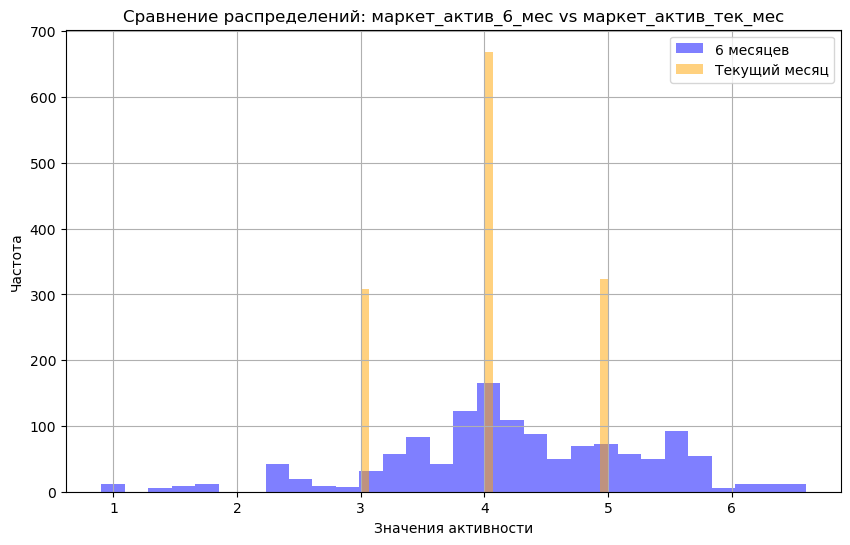

In [36]:
plt.figure(figsize=(10,6))

plt.hist(market["маркет_актив_6_мес"], bins=30, alpha=0.5, label="6 месяцев", color="blue")
plt.hist(market["маркет_актив_тек_мес"], bins=30, alpha=0.5, label="Текущий месяц", color="orange")

plt.xlabel("Значения активности")
plt.ylabel("Частота")
plt.title("Сравнение распределений: маркет_актив_6_мес vs маркет_актив_тек_мес")
plt.legend()
plt.grid(True)

plt.show()

Частота маркетинговой активности мультимодальна с модой 4 и локальной модой вц 5.5 коммуницаций в месяц. Так же заметны значения близкие к выбросам до 2 коммуникаций в месяц.

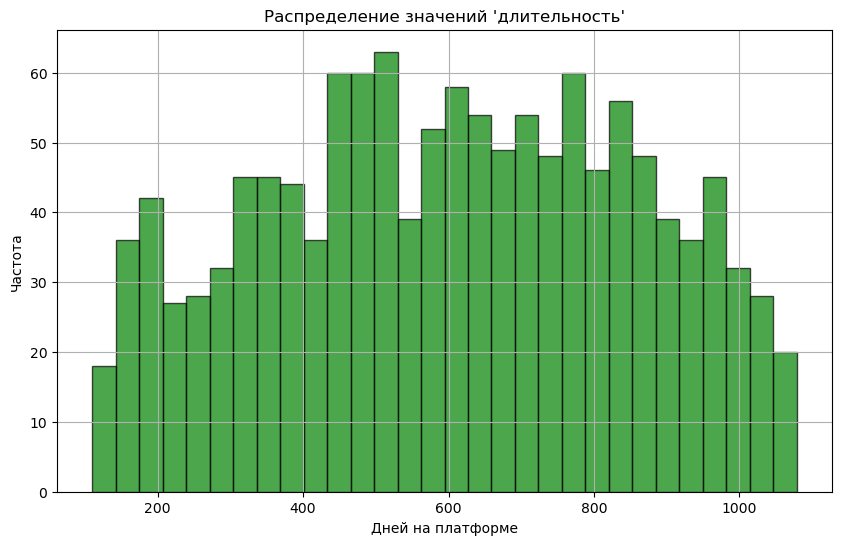

In [37]:
plt.figure(figsize=(10,6))

plt.hist(market["длительность"], bins=30, color="green", edgecolor="black", alpha=0.7)

plt.xlabel("Дней на платформе")
plt.ylabel("Частота")
plt.title("Распределение значений 'длительность'")
plt.grid(True)

plt.show()

Длительность пребывания пользователей на платформе распределена схоже с нормальным распеределением без явных выбросов и аномалий.

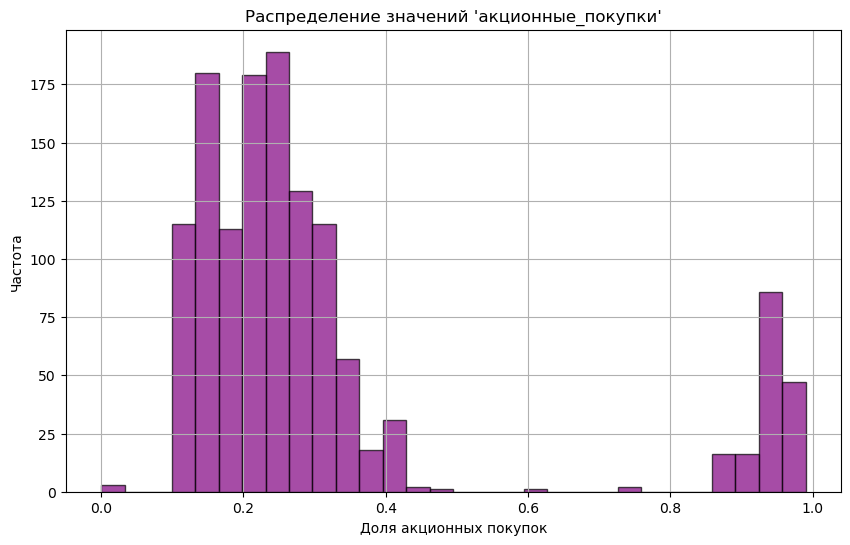

In [38]:
plt.figure(figsize=(10,6))

plt.hist(market["акционные_покупки"], bins=30, color="purple", edgecolor="black", alpha=0.7)

plt.xlabel("Доля акционных покупок")
plt.ylabel("Частота")
plt.title("Распределение значений 'акционные_покупки'")
plt.grid(True)

plt.show()

Доля акционных покупок распределена мультимодельно. Большинство пользователей покупает лишь треть покупок по акции. Но так же видно меньшее, но значимое, количество пользователей, которые стремятся покупать все товары по акции. 

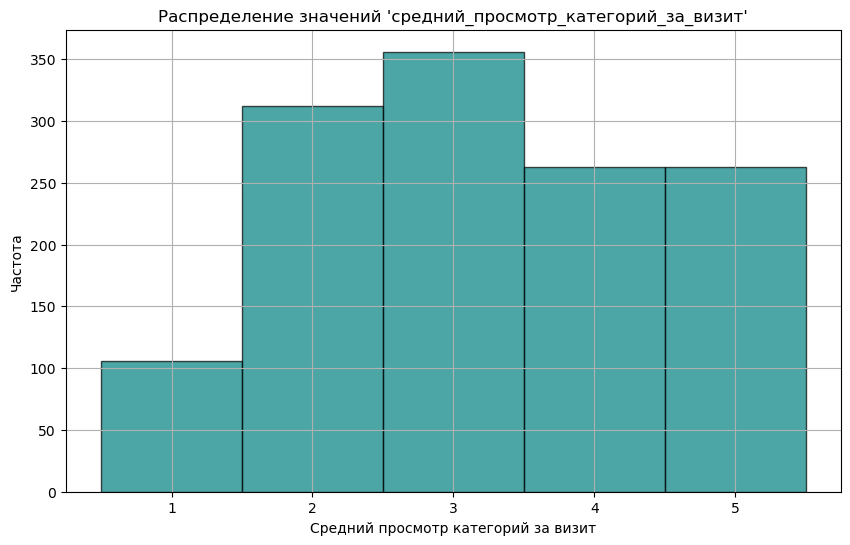

In [39]:
plt.figure(figsize=(10,6))

plt.hist(market["средний_просмотр_категорий_за_визит"], 
         bins=range(market["средний_просмотр_категорий_за_визит"].min(), 
                    market["средний_просмотр_категорий_за_визит"].max() + 1), 
         align="left", color="teal", edgecolor="black", alpha=0.7)

plt.xlabel("Средний просмотр категорий за визит")
plt.ylabel("Частота")
plt.title("Распределение значений 'средний_просмотр_категорий_за_визит'")
plt.grid(True)

plt.show()

Большинство пользователей просматривает от 2 до 5 категорий за визит.

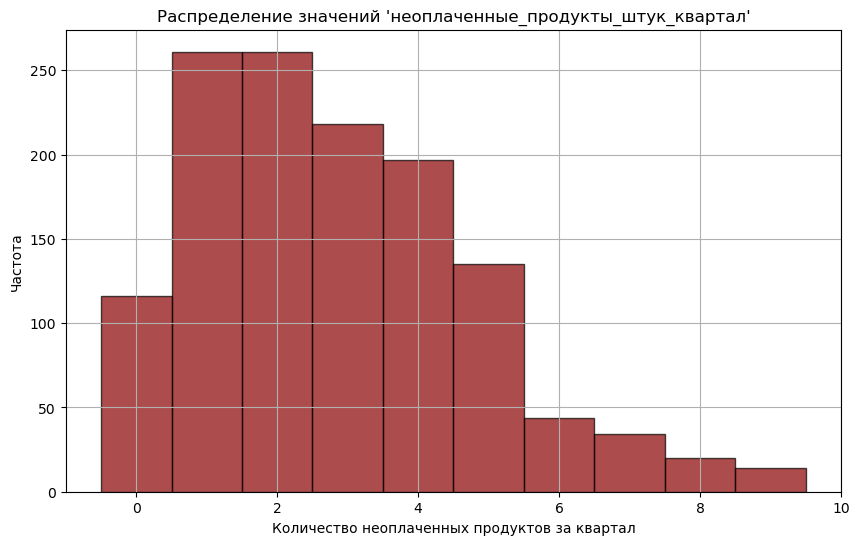

In [40]:
plt.figure(figsize=(10,6))

plt.hist(market["неоплаченные_продукты_штук_квартал"], 
         bins=range(market["неоплаченные_продукты_штук_квартал"].min(), 
                    market["неоплаченные_продукты_штук_квартал"].max() + 1), 
         align="left", color="darkred", edgecolor="black", alpha=0.7)

plt.xlabel("Количество неоплаченных продуктов за квартал")
plt.ylabel("Частота")
plt.title("Распределение значений 'неоплаченные_продукты_штук_квартал'")
plt.grid(True)

plt.show()

Распределение количества оставленных в корзине без покупки товаров напоминает распределение Пуассона. Чаще всего пользователи оставляют около 2 таваров в корзине в течение 3 месяцев неоплеченными.

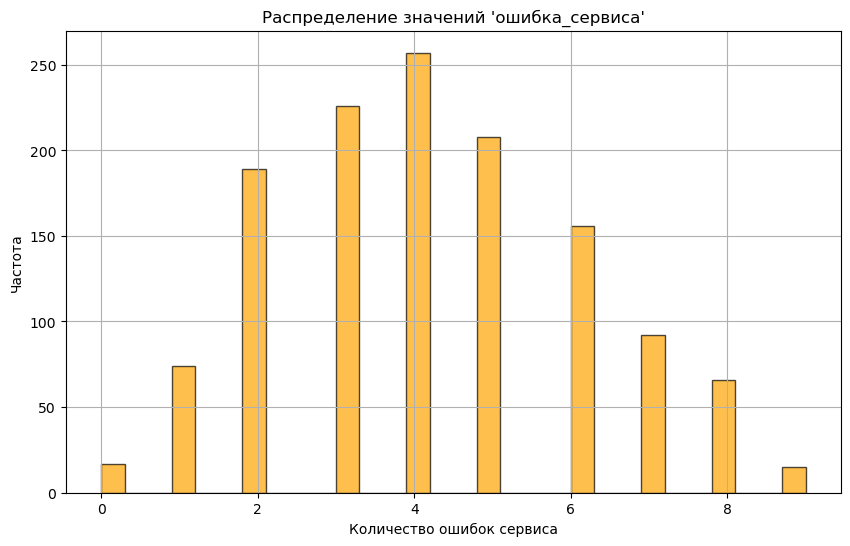

In [41]:
plt.figure(figsize=(10,6))

plt.hist(market["ошибка_сервиса"], bins=30, color="orange", edgecolor="black", alpha=0.7)

plt.xlabel("Количество ошибок сервиса")
plt.ylabel("Частота")
plt.title("Распределение значений 'ошибка_сервиса'")
plt.grid(True)

plt.show()

Количество ошибок сервиса, с которыми сталкиваются пользователи в течение квартала при посещении сайта распределно нормально со средним значением в 4 ошибки за 3 месяца.

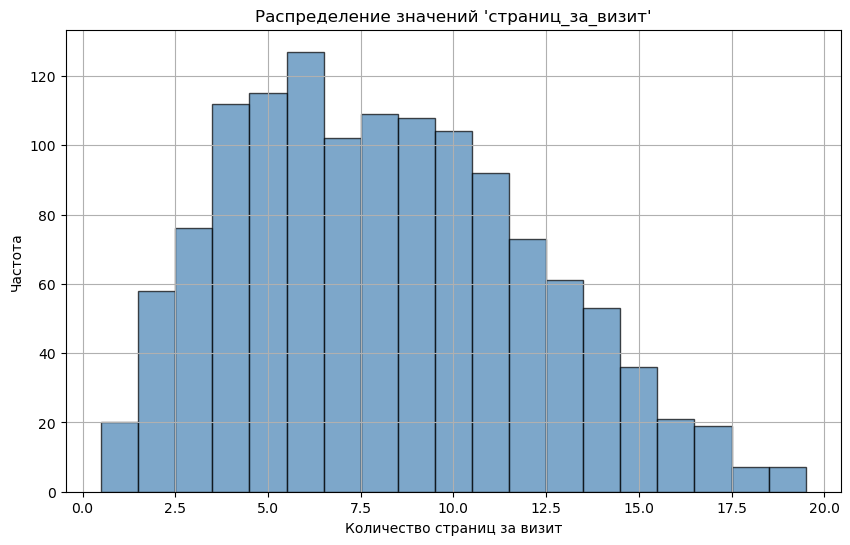

In [42]:
plt.figure(figsize=(10,6))

plt.hist(market["страниц_за_визит"], 
         bins=range(market["страниц_за_визит"].min(), 
                    market["страниц_за_визит"].max() + 1), 
         align="left", color="steelblue", edgecolor="black", alpha=0.7)

plt.xlabel("Количество страниц за визит")
plt.ylabel("Частота")
plt.title("Распределение значений 'страниц_за_визит'")
plt.grid(True)

plt.show()

Количество просмотренных пользователями страниц за визит в сервис распределно схоже с распределенгием Пуассона. Чаще всего пользователи просматривают около 6 страниц за сессию.

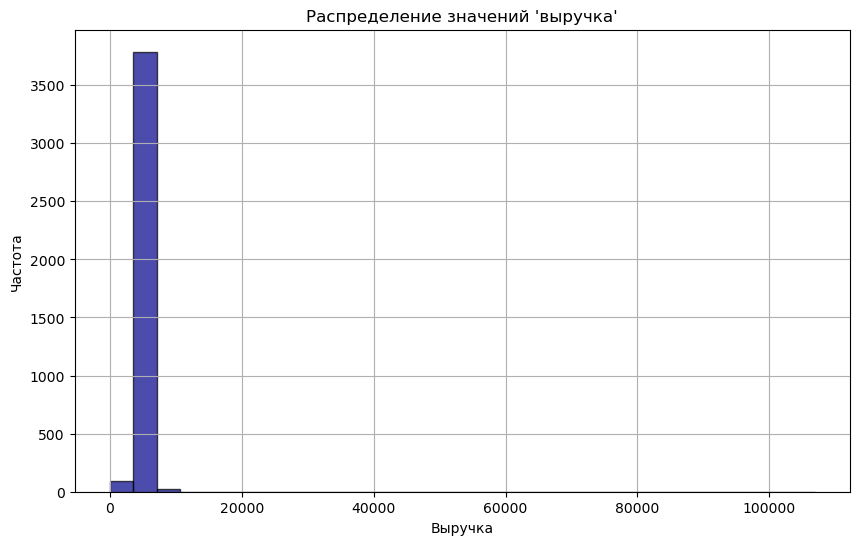

In [43]:
merged_df = pd.merge(market, market_revenue, on="id", how="inner")

plt.figure(figsize=(10,6))

plt.hist(merged_df["выручка"], bins=30, color="darkblue", edgecolor="black", alpha=0.7)

plt.xlabel("Выручка")
plt.ylabel("Частота")
plt.title("Распределение значений 'выручка'")
plt.grid(True)

plt.show()

Явно заметно наличие аномальных значений выручки на графике. Избавимся от них.

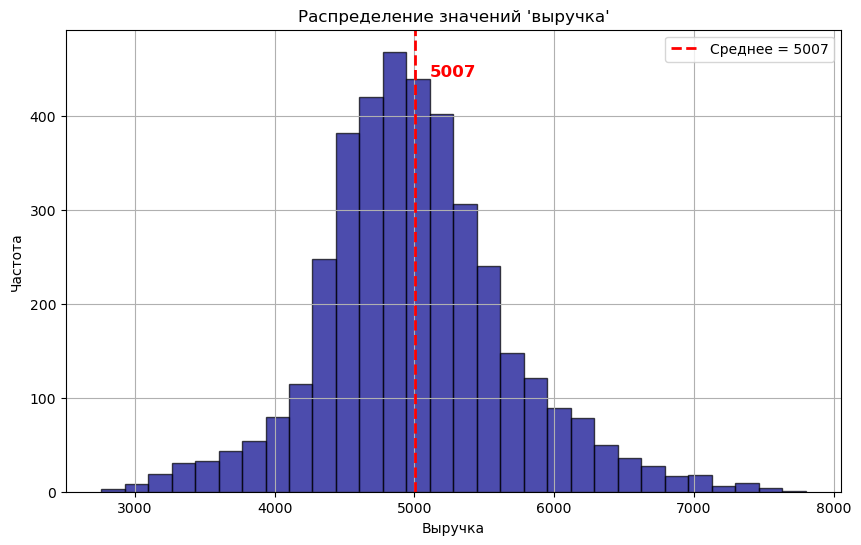

In [44]:
market_revenue = market_revenue[
    (market_revenue["выручка"] <= 20_000) & 
    (market_revenue["выручка"] > 10)
]

merged_df = pd.merge(market, market_revenue, on="id", how="inner")

mean_value = merged_df["выручка"].mean()
mean_value_rounded = round(mean_value)

plt.figure(figsize=(10,6))

plt.hist(merged_df["выручка"], bins=30, color="darkblue", edgecolor="black", alpha=0.7)
plt.axvline(mean_value, color="red", linestyle="--", linewidth=2, label=f"Среднее = {mean_value_rounded}")
plt.text(mean_value * 1.02, plt.ylim()[1]*0.9, str(mean_value_rounded), 
         color="red", fontsize=12, fontweight="bold")
plt.xlabel("Выручка")
plt.ylabel("Частота")
plt.title("Распределение значений 'выручка'")
plt.grid(True)
plt.legend()

plt.show()


После фильтрации выбросов распеределение выручки напоминает нормальное со средним в примерно 5000 у.е.

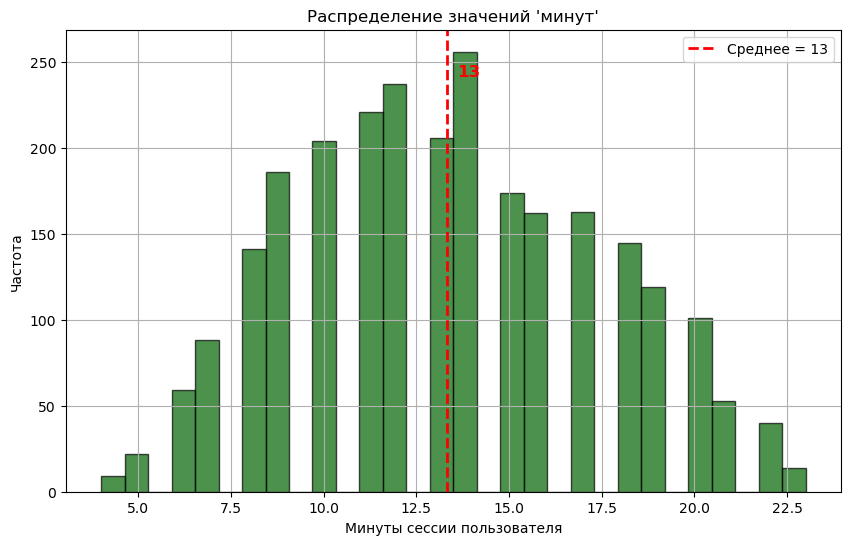

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Объединяем по id
merged_time = pd.merge(market, market_time, on="id", how="inner")

# Вычисляем среднее
mean_minutes = merged_time["минут"].mean()
mean_minutes_rounded = round(mean_minutes)

plt.figure(figsize=(10,6))

# Гистограмма
plt.hist(merged_time["минут"], bins=30, color="darkgreen", edgecolor="black", alpha=0.7)

# Вертикальная линия среднего значения
plt.axvline(mean_minutes, color="red", linestyle="--", linewidth=2, 
            label=f"Среднее = {mean_minutes_rounded}")

# Подпись справа сверху от линии
plt.text(mean_minutes * 1.02, plt.ylim()[1]*0.9, str(mean_minutes_rounded),
         color="red", fontsize=12, fontweight="bold")

# Подписи и оформление
plt.xlabel("Минуты сессии пользователя")
plt.ylabel("Частота")
plt.title("Распределение значений 'минут'")
plt.grid(True)
plt.legend()

plt.show()


Минуты распределены схоже с нормальным распределением со средним в 13 минут проведённых в сервисе за одну сессию. 

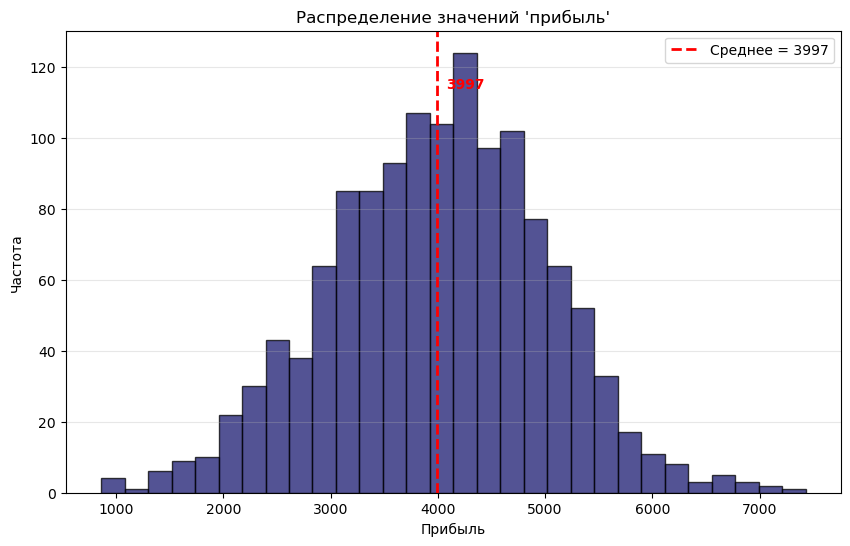

In [46]:
merged_profit = pd.merge(market, profit, on="id", how="inner")

mean_val = profit["прибыль"].mean()
mean_val_round = round(mean_val)

plt.figure(figsize=(10, 6))

plt.hist(profit["прибыль"], bins=30, color="midnightblue", edgecolor="black", alpha=0.75)
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Среднее = {mean_val_round}")
ymax = plt.ylim()[1]
plt.text(mean_val * 1.02, ymax * 0.9, str(mean_val_round),
         color="red", fontweight="bold", va="top")

plt.xlabel("Прибыль")
plt.ylabel("Частота")
plt.title("Распределение значений 'прибыль'")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()

plt.show()


Прибыль распределена схоже с нормальным распределениес со средним значением около 4000 у.е.

### Рассмотрим частоты распределения качестыенных характеристик

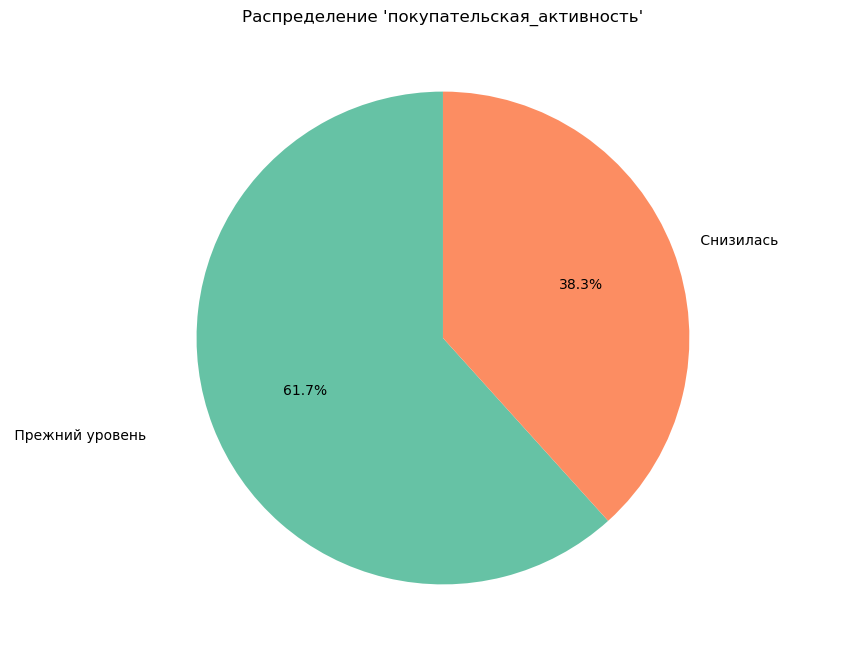

In [47]:
activity_counts = market["покупательская_активность"].value_counts()

plt.figure(figsize=(8,8))

plt.pie(activity_counts, 
        labels=activity_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=plt.cm.Set2.colors)

plt.title("Распределение 'покупательская_активность'")
plt.show()

Примерно у трети пользователей целевой признак покупательской активности снизился в последнее время

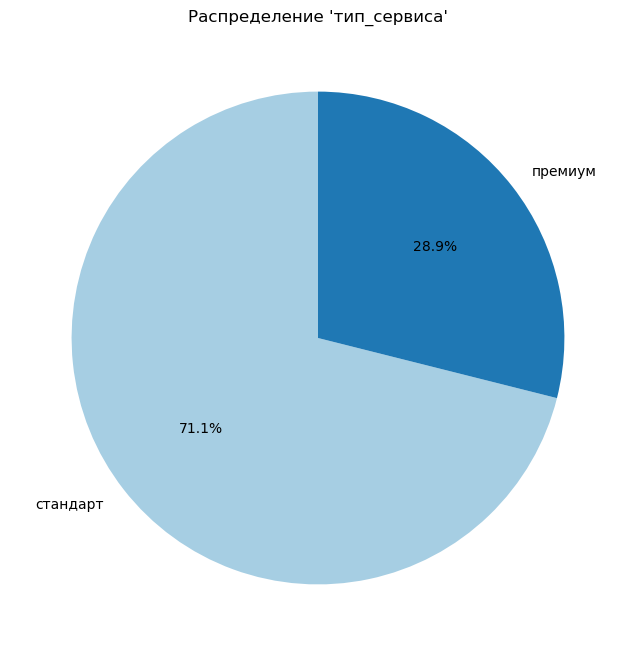

In [48]:
service_counts = market["тип_сервиса"].value_counts()

plt.figure(figsize=(8,8))

plt.pie(service_counts, 
        labels=service_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=plt.cm.Paired.colors)

plt.title("Распределение 'тип_сервиса'")
plt.show()

Чуть менее трети пользователей пользуются подпиской.

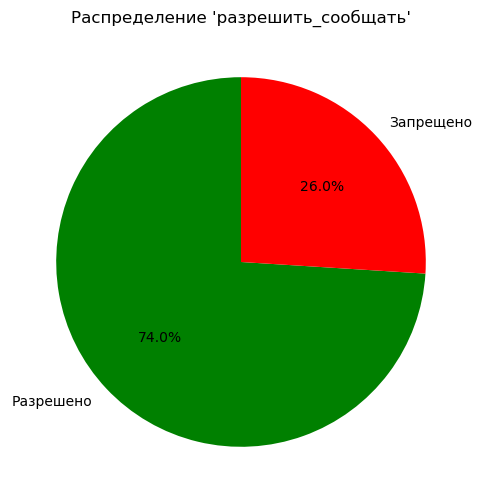

In [49]:
allow_counts = market["разрешить_сообщать"].value_counts()

plt.figure(figsize=(6,6))

plt.pie(allow_counts, 
        labels=["Разрешено", "Запрещено"], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=["green", "red"])

plt.title("Распределение 'разрешить_сообщать'")
plt.show()


Около четверти пользователей запретили присылать им маркетинговые сообщения.

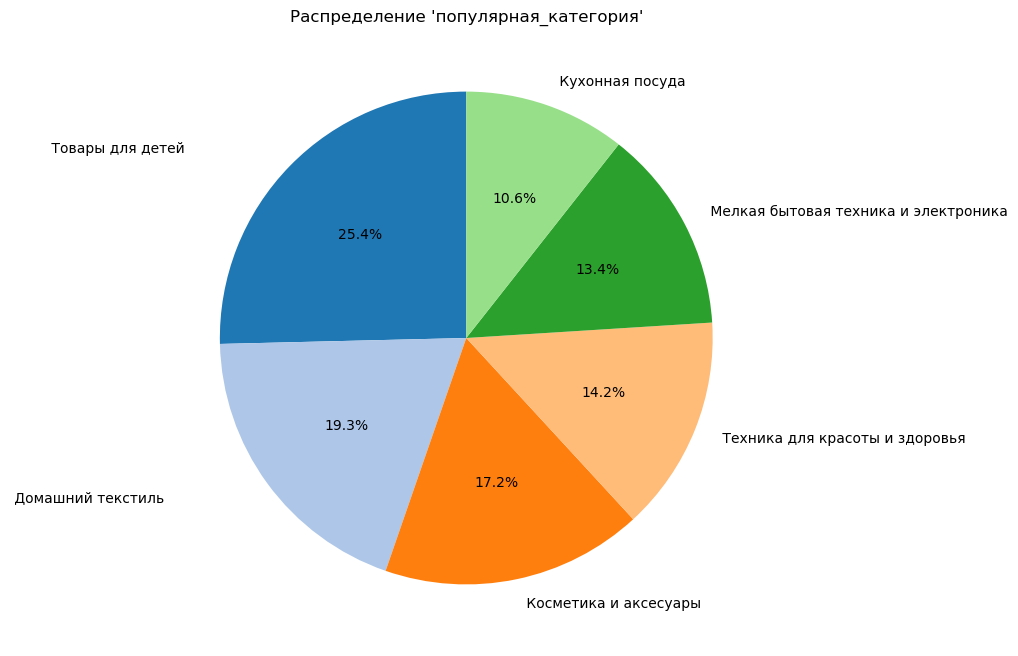

In [50]:
popular_counts = market["популярная_категория"].value_counts()

plt.figure(figsize=(8,8))

plt.pie(popular_counts, 
        labels=popular_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=plt.cm.tab20.colors)  # палитра для множества категорий

plt.title("Распределение 'популярная_категория'")
plt.show()


Чаще всего пользователи покупают товары из дщетской и текстильной категорий.

**Промежуточный вывод**:

Провели ознакомление с данными продаж, очистили данные от выбросов и аномалий.

## Объединим таблицы

In [51]:
merged_profit = pd.merge(market, profit, on="id", how="left")

Создадим новые колонки на основании периода.

In [52]:
def add_period_columns(df, col_end):
    for period in df["период"].unique():
        df = df.assign(**{
            f"{period}_{col_end}": df.apply(lambda x: x[col_end] if x["период"] == period else None, axis=1)
        })
    return df

market_time = market_time.groupby("период", group_keys=False).apply(lambda x: add_period_columns(x, "минут"))
market_time.drop("минут", axis = 1, inplace = True)

In [53]:
market_time.head()

,id,период,предыдyщий_месяц_минут,текущий_месяц_минут
1,215348,предыдyщий_месяц,13.0,NaN
3,215349,предыдyщий_месяц,12.0,NaN
5,215350,предыдyщий_месяц,8.0,NaN
7,215351,предыдyщий_месяц,11.0,NaN
9,215352,предыдyщий_месяц,8.0,NaN


In [54]:
merged_time = pd.merge(merged_profit, market_time, on="id", how="left")

Создадим новые колонки на основании периода.

In [55]:
market_revenue = market_revenue.groupby("период", group_keys=False).apply(lambda x: add_period_columns(x, "выручка"))
market_revenue.drop("выручка", axis = 1, inplace = True)

In [57]:

merged = pd.merge(merged_time, market_revenue, on="id", how="left")
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7786 entries, 0 to 7785
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   7786 non-null   int64   
 1   покупательская_активность            7786 non-null   category
 2   тип_сервиса                          7786 non-null   object  
 3   разрешить_сообщать                   7786 non-null   boolean 
 4   маркет_актив_6_мес                   7786 non-null   float64 
 5   маркет_актив_тек_мес                 7786 non-null   int64   
 6   длительность                         7786 non-null   int64   
 7   акционные_покупки                    7786 non-null   float64 
 8   популярная_категория                 7786 non-null   category
 9   средний_просмотр_категорий_за_визит  7786 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   7786 non-null   int64   
 11  ошибка_сервиса   

In [ ]:
own_herd = own_herd[own_herd["yield"] < 15000]
_, ax = plt.subplots()
ax.set_title('Надой коров')
ax.set_xlabel("Молока за год, кг")
ax.set_ylabel("Количество коров с таким надоем")
own_herd["yield"].hist(bins=50)

Надой распределён унимодально. Коров, имеющих большие надои меньше. В целом, достаточно редко встречаются коровы с надоем больше 6900 кг в год.

In [ ]:
_, ax = plt.subplots()
ax.set_title('Питательность корма коров')
ax.set_xlabel("Питательность корма")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["EFU"].hist(bins=50)

На графике видно, что нескольким коровам попался корм с очень низкой энергетической ценностью. Стоит запомнить эту особенность и в дальнейшем решить, что с этим делать. Так же виден выброс, есть одна корова с крайне не питательнным кормом. Удалим её из выборки.

In [ ]:
own_herd = own_herd[own_herd["EFU"] > 11.5]
_, ax = plt.subplots()
ax.set_title('Питательность корма коров')
ax.set_xlabel("Питательность корма")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["EFU"].hist(bins=50)

In [ ]:
_, ax = plt.subplots()
ax.set_title('Сахаро-протеиновое соотношение корма коров')
ax.set_xlabel("Отношение сахара к белкам")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["SPR"].hist(bins=50)

Можно выделить три группы коров по сахаро-протеиновое соотношению в их корме: менее 0.87, от 0.87 до 0.91 и более 0.91. Рассмотрим как отличаются удой и вкус молока у коров из этих групп.

In [ ]:
low_SPR = own_herd[own_herd["SPR"] < 0.87]
mid_SPR = own_herd[(own_herd["SPR"] >= 0.87) & (own_herd["SPR"] < 0.91)]
high_SPR = own_herd[own_herd["SPR"] >= 0.91]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
line11 = ax1.hist(low_SPR["yield"], bins=30, alpha = 0.4, color= 'r')
line12 = ax1.hist(mid_SPR["yield"], bins=30, alpha = 0.4, color= 'g')
line13 = ax1.hist(high_SPR["yield"], bins=30, alpha = 0.4, color= 'b')
ax1.set_title('Надой по соотношению сахара к белку в корме')
ax1.set_xlabel("Надой коров, кг")
ax1.set_ylabel("Количество коров с соответсвующим надоем")
ax1.legend(['Низкая питательность', 'Средняя питательность', 'Высокая питательность'])

line21 = ax2.bar(1, low_SPR[low_SPR["is_milk_tasty"]].shape[0] / low_SPR.shape[0], color= 'r', alpha = 0.4)
line22 = ax2.bar(2, mid_SPR[mid_SPR["is_milk_tasty"]].shape[0] / mid_SPR.shape[0], color= 'g', alpha = 0.4)
line23 = ax2.bar(3, high_SPR[high_SPR["is_milk_tasty"]].shape[0] / high_SPR.shape[0], color= 'b', alpha = 0.4)
ax2.set_title('Вкус молока по сахара к белку в корме')
ax2.set_ylabel("Вкусного молока в группе")
ax2.legend(['Высокая питательность', 'Средняя питательность', 'Низкая питательность'])

plt.tight_layout()
plt.show()

Делаем вывод что питательность корма может влиять на надой. Только корм с высокими энергетическими кормовыми единицами позволяет получить большие надои. Так же делаем вывод, что корм с низкой питательностью делает молоко невкусным.

In [ ]:
_, ax = plt.subplots()
ax.set_title('Содержание белка в корме коров')
ax.set_xlabel("Содержание белка, г")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["raw_protein"].hist(bins=50)

Видно что чаще всего коровам дают около 1750 белка в корме. Однако большая чась коров получает меньше белка в корме.

In [ ]:
_, ax = plt.subplots()
ax.set_title('Жирность молока коров')
ax.set_xlabel("Жирность молока, %")
ax.set_ylabel("Количество коров с соответствующей жирностью молока")
own_herd["fatness"].hist(bins=50)

Видим, что значения жирности молока для большинства коров находятся в диапазоне 3.55% - 3.75%. Так же есть коровы, которые дают молоко с меньшей жирностью, но это редкость. Делаем вывод, что это не выбросы, т.к. таких коров достаточно много, а распределение этого признака, похоже, логнормальное.


In [ ]:
_, ax = plt.subplots()
ax.set_title('Количество белка в молоке коров')
ax.set_xlabel("Белок, %")
ax.set_ylabel("Количество коров с соответствующим содержанием белка в молоке")
own_herd["proteins"].hist(bins=50)

Содержание белка в молоке, похоже, распеределено нормально. Заметен выброс в сторону увеличения содержания белка. Т.к. выбросы составляют малую часть выборки по этому признаку, удалим их для лучшей стабилизации модели.

In [ ]:

own_herd = own_herd[own_herd["proteins"] < 3.084]
_, ax = plt.subplots()
ax.set_title('Количество белка в молоке коров')
ax.set_xlabel("Белок, %")
ax.set_ylabel("Количество коров с соответствующим содержанием белка в молоке")
own_herd["proteins"].hist(bins=50)

Далее рассмотрим категориальные признаки.

In [ ]:
distribution = own_herd["breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Породы коров")
plt.show()

В стеде фермера немного больше коров породы Вис Бик Айдиал.

In [ ]:
distribution = own_herd["pasture_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Типы пастбищ")
plt.show()

Исправим описку и объеденим две одинаковые по сути категории.

In [ ]:
own_herd["pasture_type"].dtype

In [ ]:
own_herd["pasture_type"] = own_herd["pasture_type"].apply(lambda x: "Равнинное" if x == "Равнинные" else x)
distribution = own_herd["pasture_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Типы пастбищ")
plt.show()

Незначительно больше коров паслись на холмистых пастбищах.

In [ ]:
distribution = own_herd["ancestor_breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Порода родителя")
plt.show()

Исправим описку и объеденим две одинаковые по сути категории.

In [ ]:
own_herd["ancestor_breed"] = own_herd["ancestor_breed"].apply(lambda x: "Айдиал" if x == "Айдиалл" else x)
distribution = own_herd["ancestor_breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Порода родителя")
plt.show()

Почти одинаковое количество коров в стаде имеют происхождение Соверин и Айдиал.

In [ ]:
distribution = own_herd["is_milk_tasty"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = ['Вкусное', 'Невкусное'], autopct="%1.1f%%")
ax.set_title("Вкусовые качества молока")
plt.show()

Чуть больше половины коров в стаде фермера дают вкусное по его мнению молоко. Вызывает вопросы к фермеру, зачем он держит таких коров, если считает их молоко невкусным...

In [ ]:
distribution = own_herd["is_old"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = ["Старше 2 лет", "Моложе 2 лет"], autopct="%1.1f%%")
ax.set_title("Возраст коровы")
plt.show()

Посмотрим на таблицу родителей коров в ферме.

In [ ]:
distribution = cows_ancestor["ancestor_name"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Отец коров")
plt.show()

Ничего особенного. Далее проанализируем данные продаваемых коров.

In [ ]:
_, ax = plt.subplots()
ax.set_title('Жирность молока продаваемых коров')
ax.set_xlabel("Жирность молока, %")
ax.set_ylabel("Количество коров с соответствующей жирностью молока")
sale_herd["fatness"].hist(bins=30)

Заметно, что у большего количества продаваемых коров жирность молока ниже средних и наиболее часто встречаемых значений стада фермера. 

In [ ]:
_, ax = plt.subplots()
ax.set_title('Количество белка в молоке продаваемых коров')
ax.set_xlabel("Белок, %")
ax.set_ylabel("Количество коров с соответствующим содержанием белка в молоке")
sale_herd["proteins"].hist(bins=30)

In [ ]:
distribution = sale_herd["breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Породы продаваемых коров")
plt.show()

Продаётся одинаковое количество коров с двумя разными породами.

In [ ]:
distribution = sale_herd["pasture_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Типы пастбищ продаваемых коров")
plt.show()

Продаётся одинаковое количество коров пасущихся на двух разных типах пастбищ.

In [ ]:
distribution = sale_herd["ancestor_breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Порода родителя продаваемых коров")
plt.show()

Большинство продаваемых коров породы Соверин.

In [ ]:
distribution = sale_herd["is_old"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = ["Старше 2 лет", "Моложе 2 лет"], autopct="%1.1f%%")
ax.set_title("Возраст продаваемых коров")
plt.show()

В стаде продаваемых коров чуть больше молодых, с возрастом менее двух лет.

Распределение насыщенности белком молока продаваемых коров отличается от коров из стада фермера. Выборка меньше и содержит около половины коров с содержанием белка в молоке ниже, чем в стаде фермера.

В численных признаках коров фермера были устранены выбросы, в категориальных унифицированы классы.

При анализе сахоро-протеинового соотношения коров фермера было выявлено три группы коров по этому признаку. Дальнейший анализ показал что низкая и средняя питательность корма негативно влияет на целевые признаки надоя и вкуса молока.

Жирность молока коров фермера, похоже, распределена логнормально.

Количество белка в молоке коров фермера, похоже, распределено нормально.

Странным является факт, что частоты распределения родителя коров фермера и их породы различаются на 8.5%. В дальнейшем стоит постараться найти ответ, почему.

Большинство коров фермера в стаде взрослые, т.е. старше двух лет.

Для количественных данных имеет нужно провести стандартизацию признаков в ходе подготовки данных к обучению модели.

## Корреляционный анализ

Для начала построим кореляционную матрицу в виде тепловой карты.

In [ ]:
ax = plt.axes()
phi_k = own_herd.drop("id", axis = 1).phik_matrix(interval_cols = ["yield", "EFU", "raw_protein", "SPR", "fatness", "proteins"])
sns.heatmap(phi_k, cmap = "YlGnBu", annot = True)
ax.set_title('Зависимость всех признаков между собой')
plt.show()

Целевые признаки:
1) Надой:
    - сильно влияют на надой:
        - возраст (старше 2 лет) коровы дают молоко
        - питательности корма (EFU)
        - жирность молока
        - сахаро-протеиновое соотношение корма
    - средне влияет на надой:
        - порода отца коровы
        - количество белков в корме коровы
    - незначительно влияют на надой:
        - тип пастбища
        - вкусовые качества молока
        - порода коровы
    - почти не влияет на надой содержание белка в молоке коровы
2) Вкус молока:
    - вкус молока сильно зависит от:
        - сахаро-протеинового соотношения корма
    - в средней степени зависит от:
        - питательности корма (EFU)
        - тип пастбища
        - жирность молока
    - почти не влияют:
        - содержание белка в корме
        - надой
        - возраст (старше 2 лет) коровы
        - насыщенность молока белком
    - совершенно не влияют:
        - порода отца коровы
        - порода коровы

Зависимость признаков между собой:
- возраст коровы и питательность её корма
- жирность молока и питательность корма
- питательность корма и сахаро-протеинового соотношение корма
- возраст коровы и сахаро-протеинового соотношение корма
- сахаро-протеинового соотношение корма и возраст коровы
- жирность молока от возраста коровы


Делаем вывод, что для предсказания вкуса молока можно не использовать признаки, касающиеся породы коровы. Так же полезно рассмотреть типы зависимости для признаков с высокой и средней зависимостью с целевыми и так же построить зависимости выделенных выше прогнозных признаков между собой.

Построим наглядно зависимости целевых признаков от прогнозных.

In [ ]:
features = [
        ("EFU", "Питательность корма"), 
        ("proteins", "Содержание белка в молоке"), 
        ("SPR", "Сахаро-протеиновое соотношение"), 
        ("raw_protein", "Содержание белка в корме"), 
        ("fatness", "Жирность молока")
    ]

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, (feature, feature_name) in enumerate(features):
    color = ["green" if is_milk_tasty else "red" for is_milk_tasty in own_herd["is_milk_tasty"]]
    x = idx % 3
    y = idx // 3
    sct = ax[y, x].scatter(own_herd[feature].to_list(), own_herd["yield"].to_list(), c=color,
               alpha=0.3, edgecolors="none")
    ax[y, x].set_title(f"Надой vs {feature_name}")
    ax[y, x].set(xlabel=feature_name, ylabel="Надой")
    legend_handles = [
        mpatches.Patch(color="green", label="Вкусное молоко"),
        mpatches.Patch(color="red",   label="Невкусное молоко"),
    ]
    ax[y, x].legend(handles=legend_handles)
    ax[y, x].grid(True)
ax[-1, -1].axis('off')

plt.show()

Заметно, что надой линейно зависит от питательности корма. Так же чем выше питательность и сахаро-протеиновое соотношение корма, тем выше вкусовые качества молока. Содержание белка в молоке никак не влияет ни на жирность, ни на надой. Лучшим сахарно-протеиновым соотношением для вкуса молока являются значения выше 0.89 с исключением близким к 0.93. При этом характер зависимости сахаро-протеинового соотношения к надою нелинеен и явно показывает, что для болшьших надоев коровам стоит давать корм с соотношением выше 0.93. Содержание белка в корме почти никак не влияет на вкус и надой, что подтверждается графиком. Жирность молока положительно влияет на надой и вкус молока, но зависимость нелинейная.

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, (feature, feature_name) in enumerate(features):
    color = ["green" if breed == "Вис Бик Айдиал" else "red" for breed in own_herd["breed"]]
    x = idx % 3
    y = idx // 3
    sct = ax[y, x].scatter(own_herd[feature].to_list(), own_herd["yield"].to_list(), c=color,
               alpha=0.3, edgecolors="none")
    ax[y, x].set_title(f"Надой vs {feature_name}")
    ax[y, x].set(xlabel=feature_name, ylabel="Надой")
    legend_handles = [
        mpatches.Patch(color="green", label="Вис Бик Айдиал"),
        mpatches.Patch(color="red",   label="Рефлешн Соверинг"),
    ]
    ax[y, x].legend(handles=legend_handles)
    ax[y, x].grid(True)
ax[-1, -1].axis('off')

plt.show()

Заметно, что содержание белка в молоке породы Вис Бик Айдиал больше. Так же молоко этой породы имеет чуть большую жирность.

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, (feature, feature_name) in enumerate(features):
    color = ["green" if is_old else "red" for is_old in own_herd["is_old"]]
    x = idx % 3
    y = idx // 3
    sct = ax[y, x].scatter(own_herd[feature].to_list(), own_herd["yield"].to_list(), c=color,
               alpha=0.3, edgecolors="none")
    ax[y, x].set_title(f"Надой vs {feature_name}")
    ax[y, x].set(xlabel=feature_name, ylabel="Надой")
    legend_handles = [
        mpatches.Patch(color="green", label="Взрослая"),
        mpatches.Patch(color="red",   label="Не взрослая"),
    ]
    ax[y, x].legend(handles=legend_handles)
    ax[y, x].grid(True)
ax[-1, -1].axis('off')

plt.show()

Возраст коров менее двух лет очевидным образом влияет на мелкие надои.

In [ ]:
own_herd["pasture_type"].value_counts()

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, (feature, feature_name) in enumerate(features):
    color = ["green" if pasture_type == "Равнинное" else "red" for pasture_type in own_herd["pasture_type"]]
    x = idx % 3
    y = idx // 3
    sct = ax[y, x].scatter(own_herd[feature].to_list(), own_herd["yield"].to_list(), c=color,
               alpha=0.3, edgecolors="none")
    ax[y, x].set_title(f"Надой vs {feature_name}")
    ax[y, x].set(xlabel=feature_name, ylabel="Надой")
    legend_handles = [
        mpatches.Patch(color="green", label="Равнинное"),
        mpatches.Patch(color="red",   label="Холмистое"),
    ]
    ax[y, x].legend(handles=legend_handles)
    ax[y, x].grid(True)
ax[-1, -1].axis('off')

plt.show()

Холмистый тип пастбища незначительно влияет на большую  жирность молока и большие надои.

### Выводы о связях удоя и остальных признаков

Для анализа мультиколлениарности визуализируем связь скоррелированного с питатьельностью признака.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
color = ["green" if is_milk_tasty else "red" for is_milk_tasty in own_herd["is_milk_tasty"]]
sct = ax.scatter(own_herd["EFU"].to_list(), own_herd["fatness"].to_list(), c=color,
            alpha=0.3, edgecolors="none")
ax.set_title(f"Питательность корма vs жирность молока")
ax.set(xlabel="питательность корма", ylabel="жирность молока")
legend_handles = [
    mpatches.Patch(color="green", label="Вкусное молоко"),
    mpatches.Patch(color="red",   label="Невкусное молоко"),
]
ax.legend(handles=legend_handles)
ax.grid(True)
plt.show()

- Связь надоя линейно зависима от питательности корма, нелинейно зависима от сахаро-протеинового соотношения и жирности молока, а для других количественных признаков несущественна. Так же на холмистых пастбищах надои незначительно выше.
- Для жирности молока и сахаро-протеинового соотношения корма можно ввести новые категориальные признаки с 3 значениями.
- Однозначно ответить на вопрос о мультиколлинеарности питательности корма и жирности молока не получается т.к. корреляция достаточно высокая, но диаграмма рассеяния не показывает явной связи между признаками. Вероятно, стоит дальше рассмотреть новый признак как отношение жирности молока к питательности корма т.к. питание является, вероятно, влияющим на жирность фактором. 

## Обучение модели линейной регрессии

Т.к. ранее было отмечено, что только взрослые коровы могут давать большие надои и учитывая, что физиология взрослых и молодых коров различается, стоит исключить всех коров моложе двух лет из анализа.

In [ ]:
own_herd = own_herd[own_herd["is_old"] == True]

Оставим только числовые признаки для обучения модели линейной регрессии.

In [ ]:
X = own_herd.drop([ "yield", "id", "is_milk_tasty", "is_old"], axis = 1)
y = own_herd["yield"]
X_train, X_test, y_train, y_test_1 = train_test_split(X, y, test_size=0.2)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
scaler = StandardScaler()
X_train_columns = X_train.columns
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test.reindex(columns=X_train_columns, fill_value=0))

model_1 = LinearRegression()
model_1.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)


Проанализируем качество получившейся модели.

In [ ]:
r2 = r2_score(y_test_1, y_pred_1)
print(f"Значение R2 первой модели: {r2}")

In [ ]:
residuals_1 = y_pred_1 - y_test_1
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(residuals_1, bins=50)
ax.axvline(residuals_1.mean(), color='k', linestyle='dashed', linewidth=2, label="Средний остаток")
ax.text(10.2, 5 ,'Средний остаток',rotation=45, c="b")
ax.set_title("График остатков перовй модели")
ax.set(xlabel="Остаток модели", ylabel="Частота остатка")

Заметны Выбросы в негативную сторону. Следовательно, модель иногда переоценивает значения надоя.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sct = ax.scatter(y_pred_1, residuals_1, alpha=0.6, edgecolors="none")
ax.set_title(f"Рассеяние остатков перовй модели")
ax.set(xlabel="Прогноз модели", ylabel="Остаток модели")
plt.show()

Видно два кластера остатков и два выброса. Причём до 6100 литров надля в год остатки линейно зависят от надоя и ошибка предсказания модели линейно увеличивается для надоя в интервале от 5400 до 6100 литров в год. При показателях больше 6100  литров зависимость обратная и тоже похода на линейную. Следуюет выделить новые признаки и оставить те из исходных, которые лучше всего отражают линеёную связь с надоем.

Видно два кластера остатков и два выброса. Причём до 6100 литров надля в год остатки линейно зависят от надоя и ошибка предсказания модели линейно увеличивается для надоя в интервале от 5400 до 6100 литров в год. При показателях больше 6100  литров зависимость обратная и тоже похода на линейную. Следуюет выделить новые признаки и оставить те из исходных, которые лучше всего отражают линеёную связь с надоем.

### Создание признаков

Создадим категориальные признаки для сахаро-протеинового соотношения корма и жирности молока.

In [ ]:
SPR_lower_border = 0.87
SPR_upper_border = 0.92
own_herd["SPR_class"] = own_herd["SPR"].apply(lambda x: "low" \
    if x < SPR_lower_border else ("high" if x >= SPR_upper_border \
                else "mid"))

fatness_lower_border = 3.55
fatness_upper_border = 3.65
own_herd["fatness_class"] = own_herd["fatness"].apply(lambda x: "low" \
    if x < fatness_lower_border else ("high" if x >= fatness_upper_border \
                else "mid"))

Добавим так же синтетический признак: отношение жирности молока к питательности корма. 

In [ ]:
own_herd["fat_protein_ratio"] = own_herd["fatness"] / own_herd["proteins"]

Проверим информатичность синтетического признака для предсказания надоя.

In [ ]:
phi_k = own_herd.drop("id", axis = 1).phik_matrix(interval_cols = ["yield", "fat_protein_ratio"])
corr = phi_k["yield"]["fat_protein_ratio"]
print(f"Корреляция надоя с жиро-белковым соотношением: {corr * 100:.2f}%")

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sct = ax.scatter(own_herd["fat_protein_ratio"], own_herd["yield"], alpha=0.6, edgecolors="none")
ax.set_title(f"Надой к жиро-белковому соотношению")
ax.set(xlabel="Отношение жира в молоке к белку в корме ", ylabel="Надой")
plt.show()

Сгенерированный признак оказался менее информативным, чем жирность молока т.к. корреляция этого признака с надоем ниже. 

Создадим новый признак "питательность в квадрате" (ЭКЕ в квадрате) и изучим, наскколько он информативен.

In [ ]:
own_herd["EFU_squared"] = own_herd["EFU"] ** 2

phi_k = own_herd.drop("id", axis = 1).phik_matrix(interval_cols = ["yield", "EFU_squared"])
corr = phi_k["yield"]["EFU_squared"]
print(f"Корреляция надоя квадратом питательности корма: {corr * 100:.2f}%")

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sct = ax.scatter(own_herd["EFU_squared"], own_herd["yield"], alpha=0.6, edgecolors="none")
ax.set_title(f"Надой к питательности в квадрате")
ax.set(xlabel="Питательность корма в квадрате", ylabel="Надой")
plt.show()

Характер зависимости явно не изменился. Корреляция с целевым признаком уменьшилась. На изначальном графике рассеяния питательности к надою видна почти линейная зависимость признаков. Делаем вывод, что подсказка из текста задания ложная.

### Вторая модель линейной регрессии

In [ ]:
X = own_herd.drop([ "yield", "id", "is_milk_tasty", "is_old", "EFU", "SPR", "proteins", "fatness"], axis = 1)
X_train, X_test, y_train, y_test_2 = train_test_split(X, y, test_size=0.2)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_columns = X_train.columns
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test.reindex(columns=X_train_columns, fill_value=0))

model_2 = LinearRegression()
model_2.fit(X_train, y_train)

y_pred_2 = model_2.predict(X_test)

Проанализируем качество получившейся модели.

In [ ]:
r2 = r2_score(y_test_2, y_pred_2)
print(f"Значение R2 второй модели: {r2}")

In [ ]:
residuals_2 = y_pred_2 - y_test_2
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(residuals_2, bins=50)
ax.axvline(residuals_2.mean(), color='k', linestyle='dashed', linewidth=2, label="Средний остаток")
ax.text(10.2, 5 ,'Средний остаток',rotation=45, c="b")
ax.set_title("График остатков второй модели")
ax.set(xlabel="Остаток модели", ylabel="Частота остатка")

Распределение остатков стало симметричным и без явно заметных выбросов.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sct = ax.scatter(y_pred_2, residuals_2, alpha=0.6, edgecolors="none")
ax.set_title(f"Рассеяние остатков второй модели")
ax.set(xlabel="Прогноз модели", ylabel="Остаток модели")
plt.show()

Всё ещё идно два кластера остатков. При этом разброс остатков стал чуть ниже и симметричнее для всех прогнозных значений. Модель в целом стала чуть лучше и по относительной метрике R^2 и по анализу графиков разброса остатков.

### Третяя модель линейной регрессии

Объединим таблицы для добавления нового признака.

In [ ]:
own_herd = pd.merge(own_herd, cows_ancestor, on="id")

Проанализируем связь нового признака с целевым.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sct = ax.scatter(own_herd["ancestor_name"], own_herd["yield"], alpha=0.6, edgecolors="none")
ax.set_title(f"Надой к кличке родителя")
ax.set(xlabel="Кличка родителя", ylabel="Надой")
plt.show()

Подготовим данные и обучим третью модель.

In [ ]:
X = own_herd.drop([ "yield", "id", "is_milk_tasty", "is_old", "EFU", "SPR", "proteins", "fatness"], axis = 1)
X_train_3, X_test, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2)
X_train_3 = pd.get_dummies(X_train_3, drop_first=True)
train_cols = X_train_3.columns
X_test = pd.get_dummies(X_test, drop_first=True)
scaler = StandardScaler()
scaler.fit(X_train_3)
X_train_3 = scaler.transform(X_train_3)
X_test = scaler.transform(X_test)

model_3 = LinearRegression()
model_3.fit(X_train_3, y_train_3)

y_pred_3 = model_3.predict(X_test)

Проанализируем качество получившейся модели.

In [ ]:
r2 = r2_score(y_test_3, y_pred_3)
print(f"Значение R2 третей модели: {r2}")

In [ ]:
residuals_3 = y_pred_3 - y_test_3
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(residuals_3, bins=50)
ax.axvline(residuals_3.mean(), color='k', linestyle='dashed', linewidth=2, label="Средний остаток")
ax.text(10.2, 5 ,'Средний остаток',rotation=45, c="b")
ax.set_title("График остатков третей модели")
ax.set(xlabel="Остаток модели", ylabel="Частота остатка")

Среднее значение остатков не совпадает с модой, но находится очень близко к нулю. График получившейся частоты распределения напоминает нормальный, однако мода не равна среднему. Сильных выбросов нет.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sct = ax.scatter(y_pred_3, residuals_3, alpha=0.6, edgecolors="none")
ax.set_title(f"Рассеяние остатков третей модели")
ax.set(xlabel="Прогноз модели", ylabel="Остаток модели")
plt.show()

Кластеры остатков незаметны. Разброс остатков стал чуть менее симметричным относительно нуля остатков. Выьросы не наблюдаются. По метрике R^2 третяя модель чуть хуже второй. В целом учитывая равномерность распределения ошибок относительно целевого признака вторая и третяя модели сопоставимы по качеству.

### Сравнение метрик моделей

In [ ]:
mse = []
mrse = []
mae = []

for i in range(1, 4):
   mse.append(mean_squared_error(globals()[f"y_test_{i}"], globals()[f"y_pred_{i}"]))
   mrse.append(mean_squared_error(globals()[f"y_test_{i}"], globals()[f"y_pred_{i}"], squared=False))
   mae.append(mean_absolute_error(globals()[f"y_test_{i}"], globals()[f"y_pred_{i}"]))

In [ ]:
metric_names = ["Среднеквадратичная ошибка", "Корень среднеквадратичной ошибки", "Средняя абсолютная ошибка"]
models = ['Модель ' + str(i) for i in range(1, 4)]
values = [mse, mrse, mae]

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(0, 3):
    ax[i].bar(models, values[i])
    ax[i].set_ylabel(metric_names[i])
    ax[i].set_title(f'{metric_names[i]} моделей')
    ax[i].grid(True)

plt.show()

Исходя из всех доступных метрик моделей, третяя модель наилучшая по качеству.

Посчитаем доверительный интервал прогноза модели.

In [ ]:
fig, ax = plt.subplots()
bp = ax.boxplot(model_3.predict(X_train_3) - y_train_3)
q1 = bp['boxes'][0].get_path().vertices[0, 1]
median = bp['medians'][0].get_ydata()[0]
q3 = bp['boxes'][0].get_path().vertices[2, 1]
lower_whisker = bp['caps'][0].get_ydata()[0]
upper_whisker = bp['caps'][1].get_ydata()[0]
iqr = q3 - q1
values = [lower_whisker, q1, median, q3, upper_whisker]
labels = [
    f'Нижний ус: {lower_whisker:.2f}',
    f'Q1 (25%): {q1:.2f}',
    f'Медиана (Q2): {median:.2f}',
    f'Q3 (75%): {q3:.2f}',
    f'Верхний ус: {upper_whisker:.2f}'
]

for y, label in zip(values, labels):
    ax.hlines(y, xmin=0, xmax=1, color='gray', linestyle='--')
    ax.text(-0.1, y, label, transform=ax.get_yaxis_transform(), ha='right', va='center')
ax.set_title('Визуализация доверительного интервала')
plt.show()

В предсказаниях модели с остатками в отрезке [-128, 124] можно быть уверенными.

### Прогноз надоя продаваемых коров

Добавим недостающие признаки в соответствии с условием задачи.

In [ ]:
new_columns = own_herd[["EFU", "raw_protein", "SPR"]]

for col in new_columns:
    sale_herd[col] = new_columns[col].mean() * 1.05



Отфильтруем не взрослых коров.

In [ ]:
regress_sale_herd = sale_herd[sale_herd["is_old"]]

Сгенерируем новые признаки.

In [ ]:
SPR_lower_border = 0.87
SPR_upper_border = 0.92
regress_sale_herd.loc[:, "SPR_class"] = regress_sale_herd["SPR"].apply(lambda x: "low" \
    if x < SPR_lower_border else ("high" if x >= SPR_upper_border \
                else "mid"))

fatness_lower_border = 3.55
fatness_upper_border = 3.65
regress_sale_herd.loc[:, "fatness_class"] = regress_sale_herd["fatness"].apply(lambda x: "low" \
    if x < fatness_lower_border else ("high" if x >= fatness_upper_border \
                else "mid"))
regress_sale_herd.loc[:, "fat_protein_ratio"] = regress_sale_herd["fatness"] / regress_sale_herd["proteins"]
regress_sale_herd.loc[:, "EFU_squared"] = regress_sale_herd["EFU"] ** 2

Спрогнозируем надои коров лучшей моделью.

In [ ]:
regress_sale_herd = regress_sale_herd.astype({"raw_protein": "int64",
    "pasture_type": "object",
    "ancestor_breed": "object"
    })
X_new_encoded = pd.get_dummies(regress_sale_herd, drop_first=True).reindex(columns=train_cols, fill_value=0)
X_new_scaled = StandardScaler().fit_transform(X_new_encoded)
y_pred_new = model_3.predict(X_new_scaled)

In [ ]:
X_new_encoded["yuield_prediction"] = y_pred_new
y_pred_new = X_new_encoded
y_pred_new

## Обучение модели логистической регрессии

In [ ]:
X = own_herd.drop([ 
    "id", "is_milk_tasty", "is_old", "breed", "ancestor_breed", "ancestor_name"
    ], axis = 1)
y = own_herd["is_milk_tasty"]
X_train_4, X_test, y_train_4, y_test_4 = train_test_split(X, y, test_size=0.2)
y_train_4 = y_train_4.astype(int)
y_test_4 = y_test_4.astype(int)
X_train_4 = pd.get_dummies(X_train_4, drop_first=True)
log_train_cols = X_train_4.columns
X_test = pd.get_dummies(X_test, drop_first=True)
scaler = StandardScaler()
scaler.fit(X_train_4)
X_train_4 = scaler.transform(X_train_4)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
clf = clf.fit(X_train_4, y_train_4)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

Оценим метрики модели классификации.

In [ ]:
def print_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f"Доля верных предсказаний: {accuracy:.3f}\nТочность: {precision:.3f}\nПолнота: {recall:.3f}")

print_metrics(y_test_4, y_pred)

Далее расспотрим матрицу ошибок.

In [ ]:
sns.heatmap(confusion_matrix(y_test_4, y_pred), annot=True)
plt.ylabel("Значение истинности")
plt.xlabel("Предсказание")
plt.title("Матрица ошибок")

Т.к. цель найти коров со вкусным молоком, нужно минимизировать ложноположительные результаты предсказания, FP, поэтому будем минимизировать ошибку первого рода, которых 20.

In [ ]:
data = pd.DataFrame(zip(y_test_4, y_proba),
                    columns = ["y_valid", "y_proba"]).sort_values(by="y_proba",ascending=False)
columns = []
thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num = 100, endpoint=False)]

for i in thresholds:
    columns.append("y_pred_"+str(i))
    data["y_pred_"+str(i)] = data["y_proba"].apply(lambda x: 1 if x > i else 0)

total_negatives = (data["y_valid"] == 0).sum()
type_1_errors = []

for thresh in thresholds:
    predicted_positives = data["y_proba"] > thresh
    false_positives = ((predicted_positives == True) & (data["y_valid"] == 0)).sum()
    fp_rate = false_positives / total_negatives if total_negatives > 0 else 0
    type_1_errors.append(fp_rate)

optimal_threshold_index = np.argmin(type_1_errors)
optimal_threshold = thresholds[optimal_threshold_index]
print(f"Оптимальный порог для минимизации ошибки первого рода: {optimal_threshold:.2f}")

plt.figure(figsize=(12, 7))
plt.plot(thresholds, type_1_errors, linestyle='-', label="Ошибка первого рода")
plt.title("Зависимость ошибки первого рода от порога классификации")
plt.xlabel("Порог")
plt.ylabel("Доля ложных срабатываний")
plt.legend()
plt.grid(True)
plt.savefig('type_1_error_plot.png')

Построим прогноз с оптимальным порогом и оценим метрики.

In [ ]:
def custom_predict(X, threshold):
    probs = clf.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

adjusted_predicts = custom_predict(X_test, threshold=0.89)
print_metrics(y_test_4, adjusted_predicts)

In [ ]:
sns.heatmap(confusion_matrix(y_test_4, adjusted_predicts), annot=True)
plt.ylabel("Значение истинности")
plt.xlabel("Предсказание")
plt.title("Матрица ошибок")

Общая точность предсказания модели значительно упала, но теперь модель не допускает ошибки, при которых она ложно выбирает коров с невкусным молоком. Это соответствует запросу бизнеса. Спрогнозируем, какие из коров из стада на продажу дадут вкусное молоко.

### Предсказание модели

Отфильтруем не взрослых коров.

In [ ]:
log_sale_herd = sale_herd[sale_herd["is_old"]]

Сгенерируем новые признаки.

In [ ]:
SPR_lower_border = 0.87
SPR_upper_border = 0.92
log_sale_herd.loc[:, "SPR_class"] = log_sale_herd["SPR"].apply(lambda x: "low" \
    if x < SPR_lower_border else ("high" if x > SPR_upper_border \
        else "mid"))

fatness_lower_border = 3.55
fatness_upper_border = 3.65
log_sale_herd.loc[:, "fatness_class"] = log_sale_herd["fatness"].apply(lambda x: "low" \
    if x < fatness_lower_border else ("high" if x > fatness_upper_border \
        else "mid"))

log_sale_herd.loc[:, "fat_protein_ratio"] = log_sale_herd["fatness"] / log_sale_herd["proteins"]
log_sale_herd.loc[:, "EFU_squared"] = log_sale_herd["EFU"] ** 2

Спрогнозируем вкус молока коров.

In [ ]:
log_sale_herd = log_sale_herd.astype({"raw_protein": "int64",
    "pasture_type": "object",
    "ancestor_breed": "object"
    })
X_new_encoded = pd.get_dummies(log_sale_herd, drop_first=True).reindex(columns=log_train_cols, fill_value=0)
X_new_scaled = StandardScaler().fit_transform(X_new_encoded)
log_y_pred = clf.predict(X_new_scaled)

In [ ]:
X_new_encoded["is_milk_tasty_prediction"] = log_y_pred
log_y_pred = X_new_encoded
log_y_pred

## Итоговые выводы

Объединим прогнозы с данными из стада на продажу.

In [ ]:
predicted_sale_herd = pd.merge(sale_herd[sale_herd["is_old"]], y_pred_new["yuield_prediction"], left_index=True, right_index=True)
good_yield = predicted_sale_herd.query("yuield_prediction > 6000")
print(f"Коров с подходящим надоем: {len(good_yield)}")
predicted_sale_herd = pd.merge(predicted_sale_herd, log_y_pred["is_milk_tasty_prediction"], left_index=True, right_index=True)
good_milk_taste = log_y_pred.query("is_milk_tasty_prediction == 1")
print(f"Коров со вкусным молоком: {len(good_milk_taste)}")
predicted_sale_herd.head()

Выберим интересных бизнесу коров.

In [ ]:
to_buy = predicted_sale_herd.query("is_milk_tasty_prediction == 1 and yuield_prediction > 6000")
to_buy

## Выводы

### Для бизнеса

Для покупки с минимальными рисками коров с удоем более 6000 л. в год и вкусным молоком подходит ***три коровы*** из стада на продажу из строк ***3, 9, 15*** в стаде на продажу. Такое малое количество вариантов обусловлено тем, что молоко должно быть вкусным и надой должен быть высоким, а коров, выставленных на продажу, изначально всего 20, т.е. немного.

В случае отсутствия новых поставщиков коров, стоит ослабить критерии выбора.

Стоит всегда рассматривать для покупки коров старше двух лет.

### Для аналитики

Модель линейной регрессии обучена с учётом анализа связей признаков в стаде фермера. При обучении лучший результат удалось добиться используя закодированные категориальные признаки и добавим новые, производные от базовых признаки. Дальнейшее улучшени е работы модели может быть связано с экспериментами по выделению новых произаодных признаков из базовых.

Модель логистической регрессии была обучена на закодированных качественных и количественных данных, а так же производных от базовых признаках. В целях улучшения качества работы модели можно экспериментировать с новыми производными признаками и оценивать рост качества модели по относительной метрике R^2. В целях анализа риков для модели классификации важно минимизировать количество ложно выбранных коров с невкусным молоком. С этой целью стоит опираться на метрику "точность" (precision)